In [21]:
# install dependencies and define constants and functions
import matplotlib.pyplot as plt
import os
import numpy as np
import copy



color = ['yellow', 'blue', 'green', 'orange', 'purple', 'cyan', 'red']


def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


directory_name = globals()['_dh'][0]

# load position data from blender
blender_cone_path = os.path.join(directory_name, 'cone_position.p3d')
blender_cone_points_3D = np.loadtxt(blender_cone_path, delimiter=';')

# load car position data from blender
blender_car_path = os.path.join(directory_name, 'car_position.p3d')
blender_car_points_3D = np.loadtxt(blender_car_path, delimiter=';')

class Result:
    def __init__(self, directory_name, points_3D, optimization_errors, color):
        self.name = os.path.basename(directory_name)
        self.points_3D = np.insert(points_3D, 3, optimization_errors, axis=1)
        self.color = color


# load results
result_paths = sorted([os.path.join(directory_name, frame_dir)
                 for frame_dir in os.listdir(directory_name)])

# add cone position to results
blender_position_path = os.path.join(directory_name, 'blender-position')
cone_points_3D = np.loadtxt(os.path.join(
    blender_position_path, 'cone_transformation.p3d'), delimiter=';')
transformed_cone_points_2D = cone_points_3D[:, :2]

results = []
i = 0
for result_path in result_paths:
    # check if result is a directory
    if os.path.isdir(result_path):
        i += 1
        points_3D = np.loadtxt(os.path.join(
            result_path, 'car_transformation.p3d'), delimiter=';')
        error = np.loadtxt(os.path.join(
            result_path, 'optimization_errors.txt'), delimiter=';')
        result = Result(result_path, points_3D, error, color[i])
        results.append(Result(result_path, points_3D, error, color[i]))




OSError: /Users/raphael/git/uni/own-forks/cone_reconstruction/blender-racetrack/results/color-tracker/car_transformation.p3d not found.

In [ ]:
# define plot
plt.rcParams['figure.dpi'] = 150  # 200 e.g. is really fine, but slower
plt.rcParams['lines.markersize'] = 2


def plotTrack(results, not_display = []):
    plt.rcParams['figure.figsize'] = [15, 10]


    plt.rcParams['figure.dpi'] = 200  # 200 e.g. is really fine, but slower
    plt.rcParams['lines.markersize'] = 2
    for result in results:
        if (result.name not in not_display):
            plt.plot(result.points_3D[:, 0], result.points_3D[:, 1],
                color=result.color, label=result.name)
    # add "real position" to plot
    plt.plot(blender_car_points_3D[:, 0],
             blender_car_points_3D[:, 1], label='real position', color='black')
    plt.plot(blender_cone_points_3D[:, 0], blender_cone_points_3D[:, 1], '^', color='black')
    # add reconstucted cone points to plot
    plt.plot(transformed_cone_points_2D[:, 0],
             transformed_cone_points_2D[:, 1], '^', color="red", label='reconstructed cones')
    plt.legend(loc='best')
    plt.ylabel("Y position in m", labelpad=15)
    plt.xlabel("X position in m", labelpad=15)

In [ ]:
def plotMSE(results, not_display = []):
    plt.rcParams['figure.figsize'] = [10, 5]

    i = 0
    for result in results:
        if (result.name not in not_display):
            i += 1
            # calculate MSE
            mse = np.mean(np.square(np.linalg.norm(
                result.points_3D[:, : 3] - blender_car_points_3D, ord=2, axis=1)))
            # dir_name
            # print(result.name, mse)
            plt.text(i, mse, str(round(mse, 2)), fontweight='bold')
            plt.bar(i, mse, 1, label=result.name, color=result.color)
    mse = np.mean(np.square(np.linalg.norm(
    cone_points_3D[:, : 3] - blender_cone_points_3D, ord=2, axis=1)))
    plt.text(i + 1, mse, str(round(mse, 2)), fontweight='bold')
    plt.bar(i + 1, mse, 1, label='Cone reconstruction', color='red')
    plt.legend(loc='best')
    plt.ylabel("Mean squared error", labelpad=15)
    plt.xticks([])


In [ ]:

def plotEuclideanDistances(results, not_display = []):
    plt.rcParams['figure.figsize'] = [10, 5]
    for result in results:
        if (result.name not in not_display):
            # calculate distances
            distances = np.linalg.norm(
                result.points_3D[:, : 3]- blender_car_points_3D, ord=2, axis=1)
            plt.plot(distances, label=result.name, color=result.color)
            plt.legend(loc='best')
            plt.ylabel("euclidean distances in m", labelpad=15)
            plt.xlabel("frame")



In [ ]:
def plotOptimizationError(results, not_display = []):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['figure.dpi'] = 200  # 200 e.g. is really fine, but slower
    plt.rcParams['lines.markersize'] = 2
    for result in results:
        if (result.name not in not_display):
            plt.plot(result.points_3D[:,3], label=result.name, color=result.color)
            plt.legend(loc='best')
            plt.ylabel("optimization error", labelpad=15)
            plt.xlabel("frame")


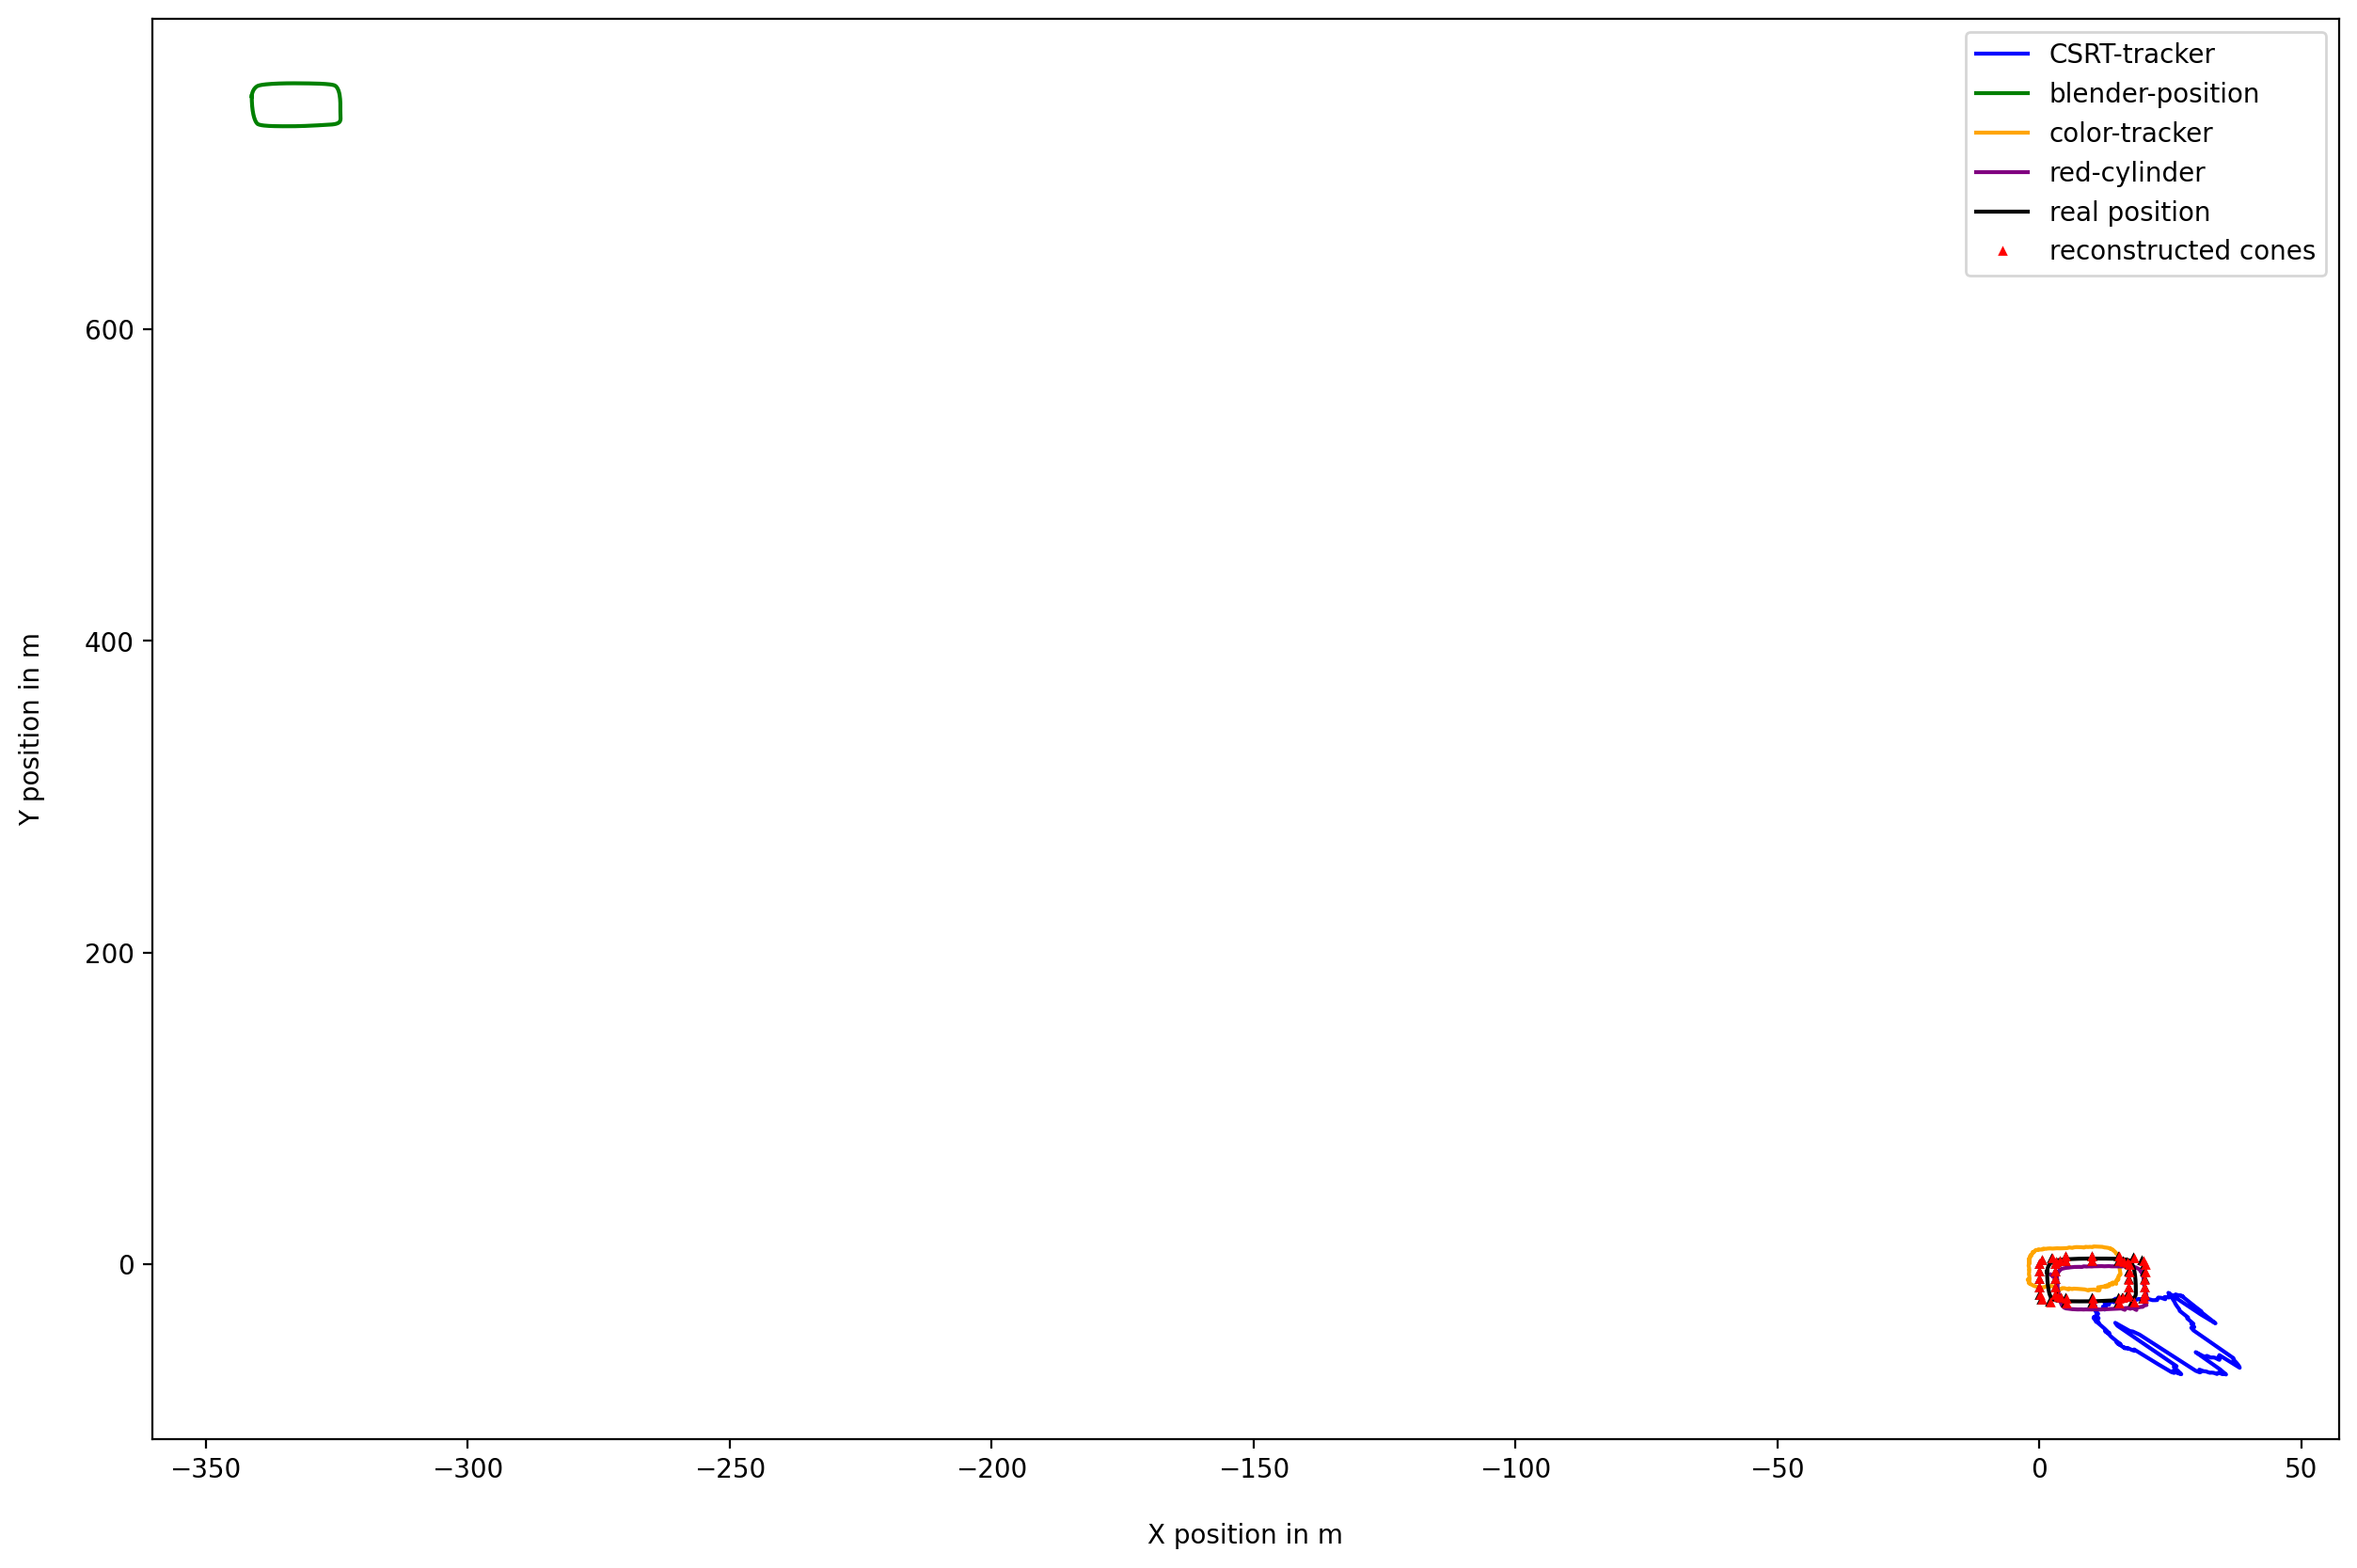

In [ ]:
# Plot initial results
plotTrack(results)

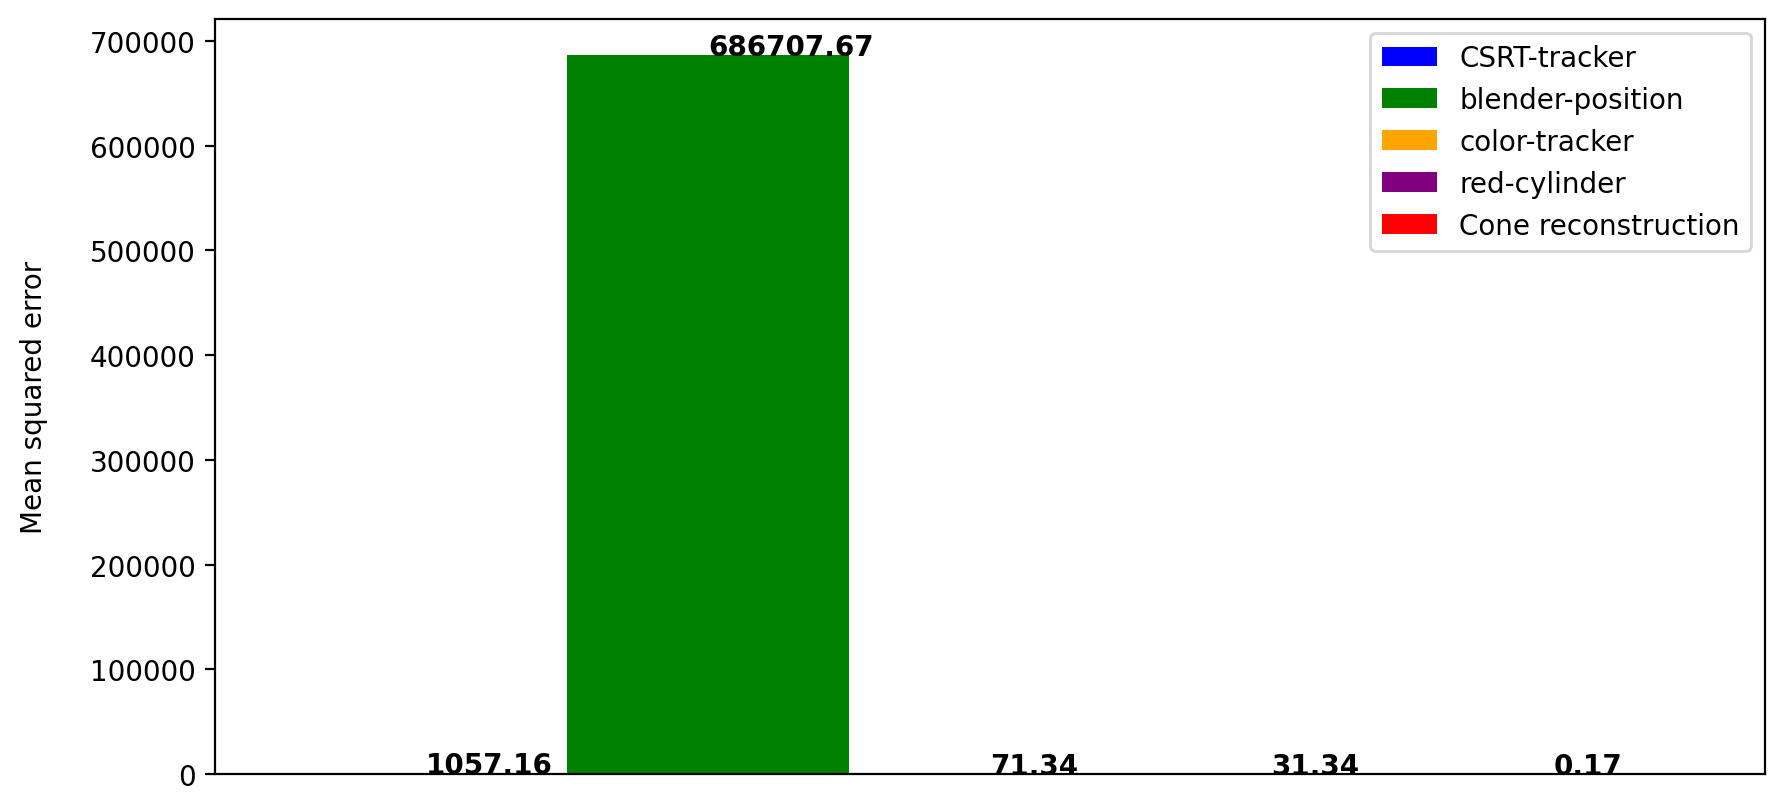

In [ ]:
plotMSE(results)

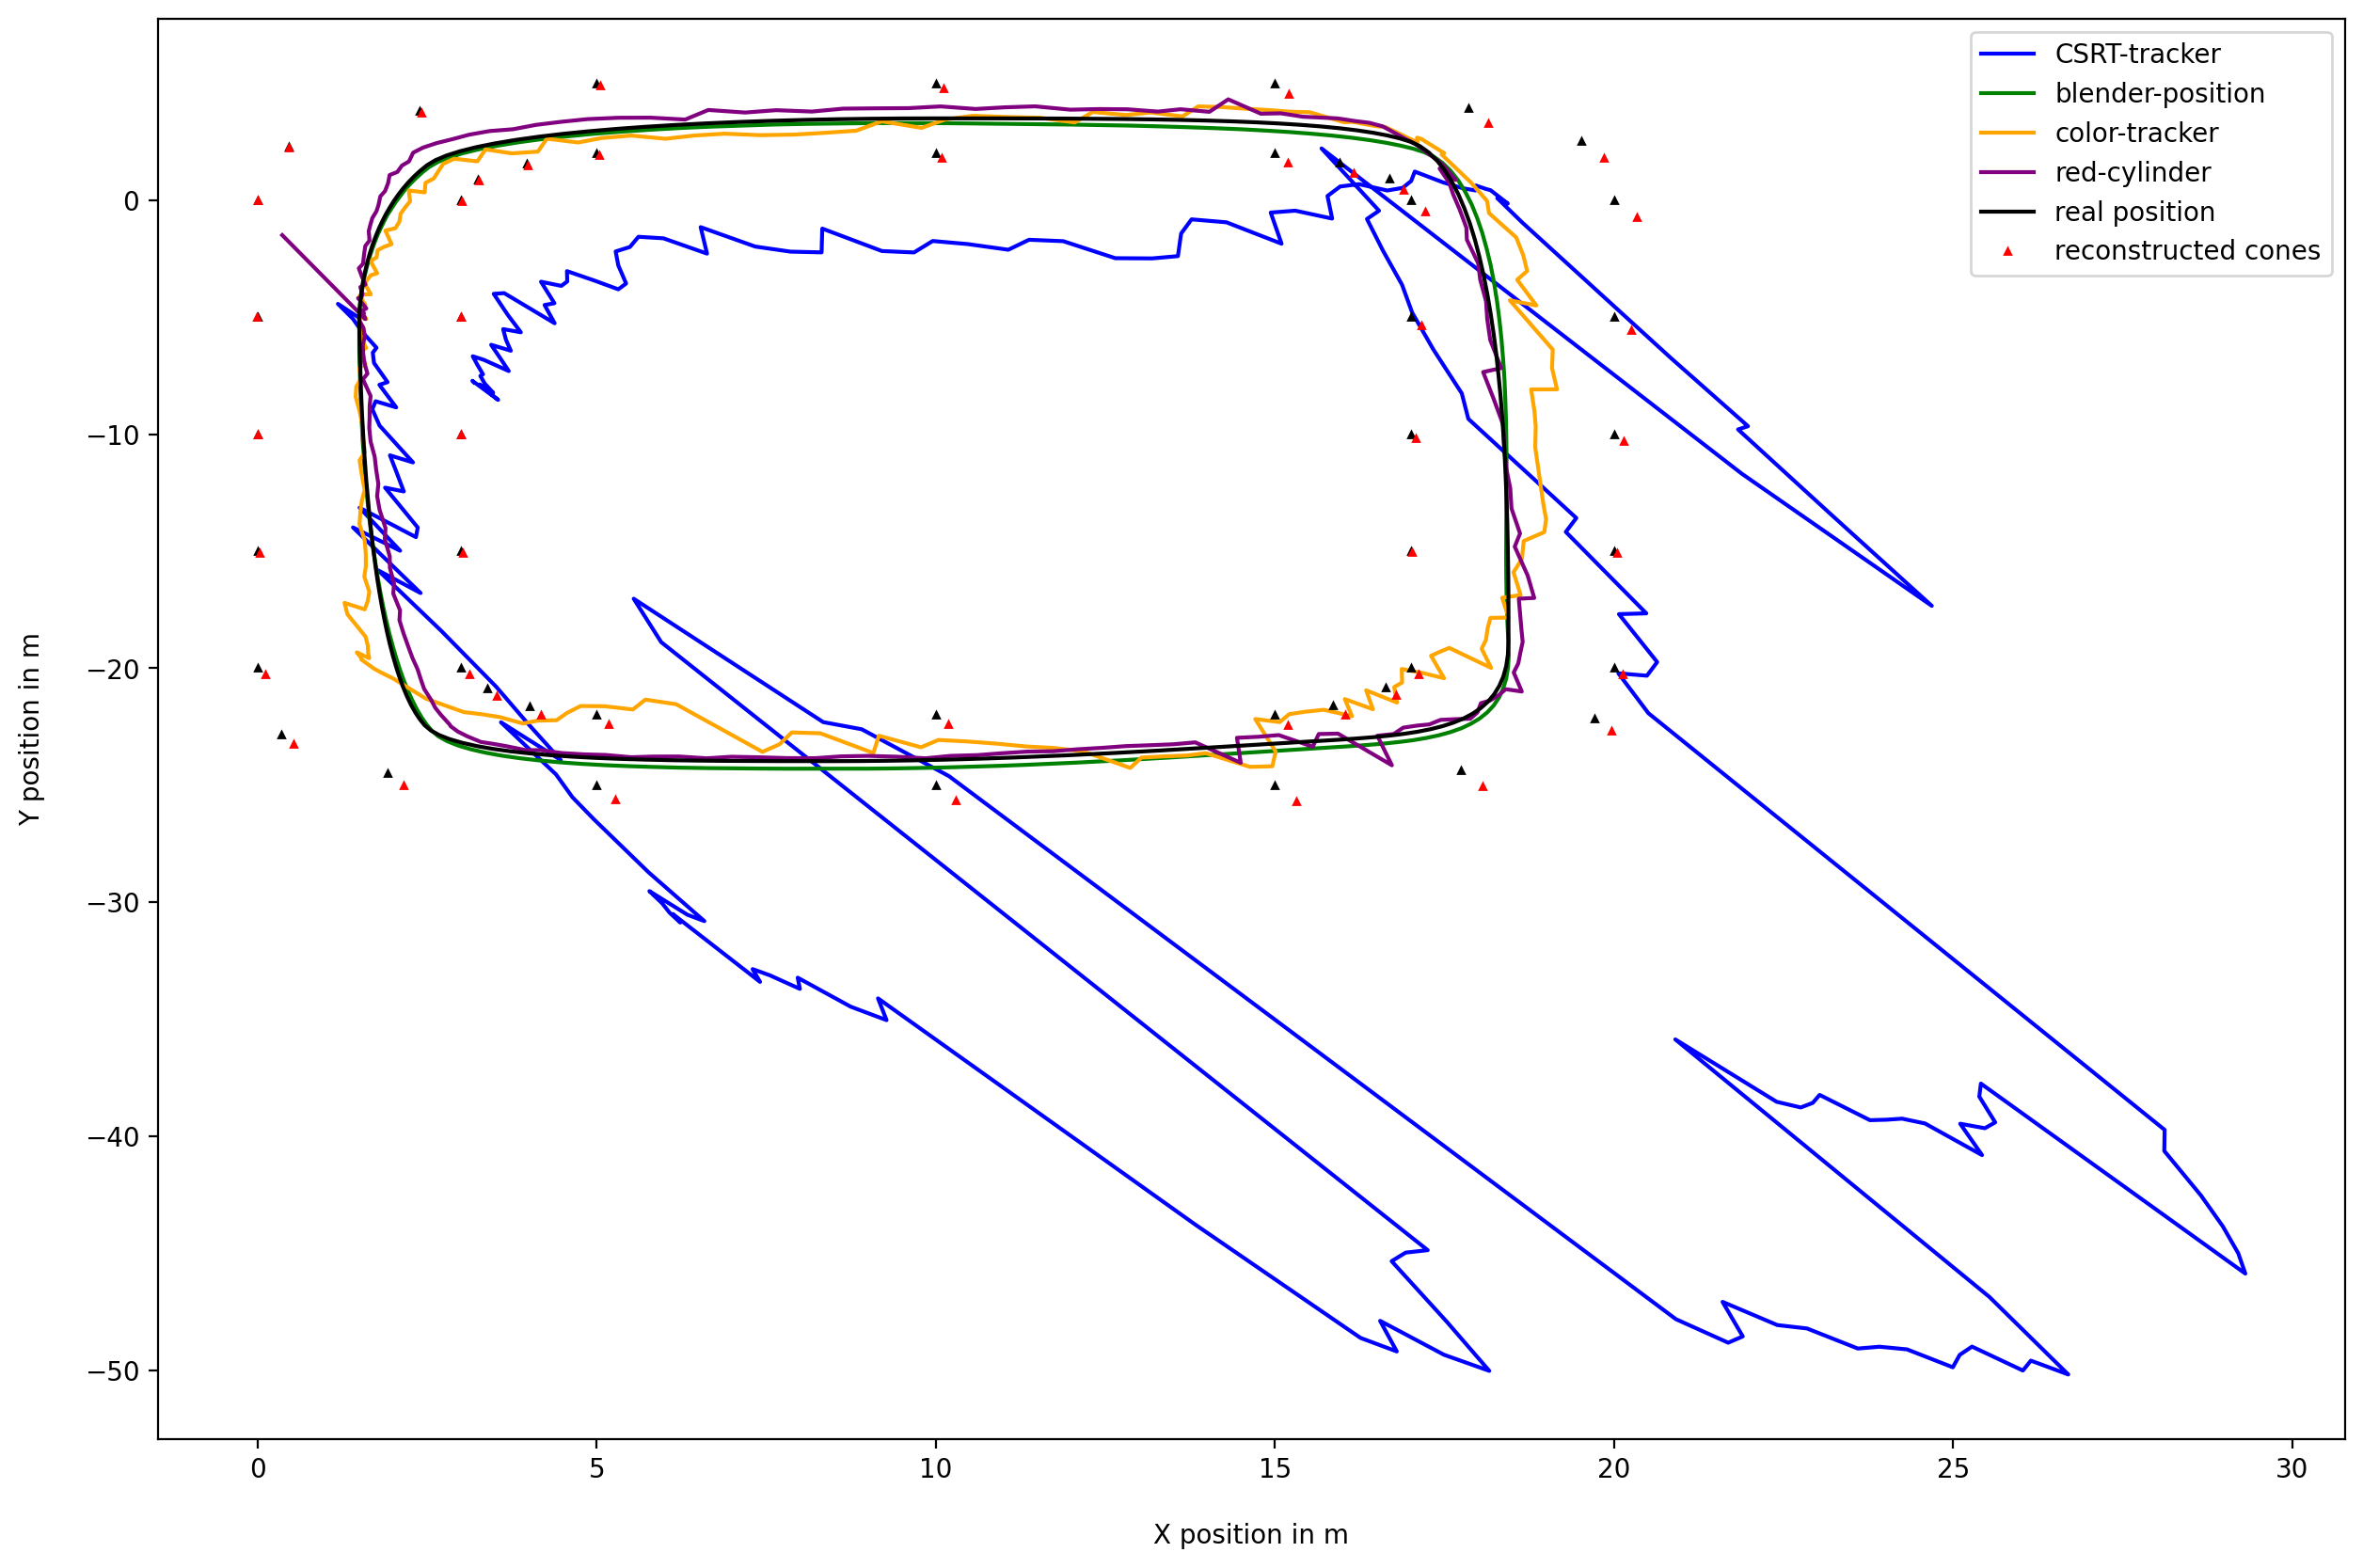

In [ ]:
# "Normalize"
normalize = copy.deepcopy(results)
for result in normalize:
    delta_points_3D = blender_car_points_3D[0] - result.points_3D[: , : 3][0]
    for point_3D in result.points_3D:
        point_3D[:3] += delta_points_3D

plotTrack(normalize)


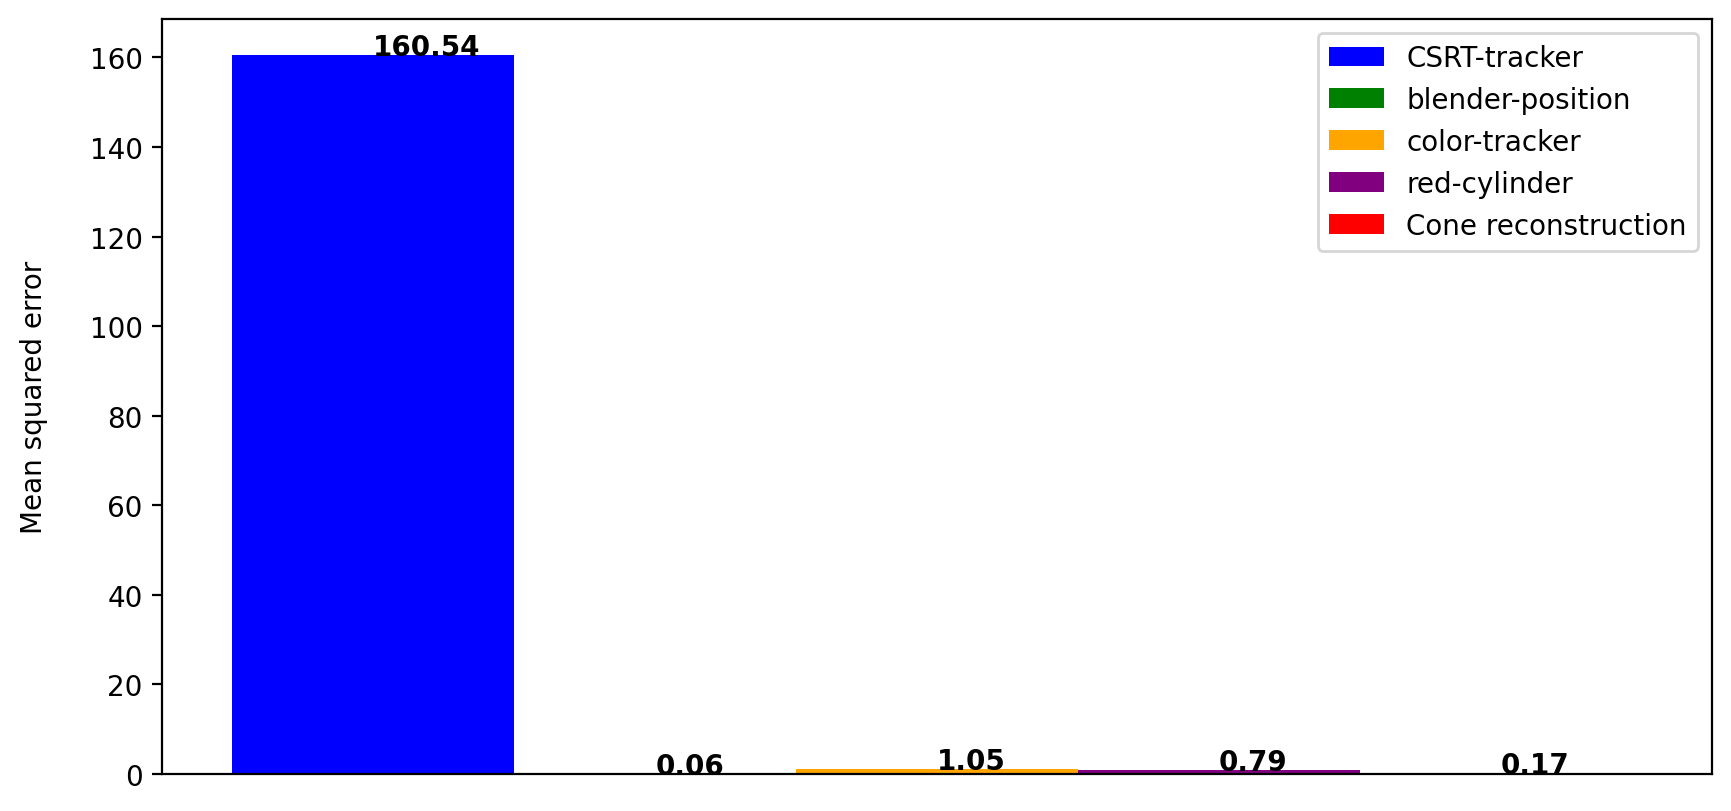

In [ ]:
plotMSE(normalize)

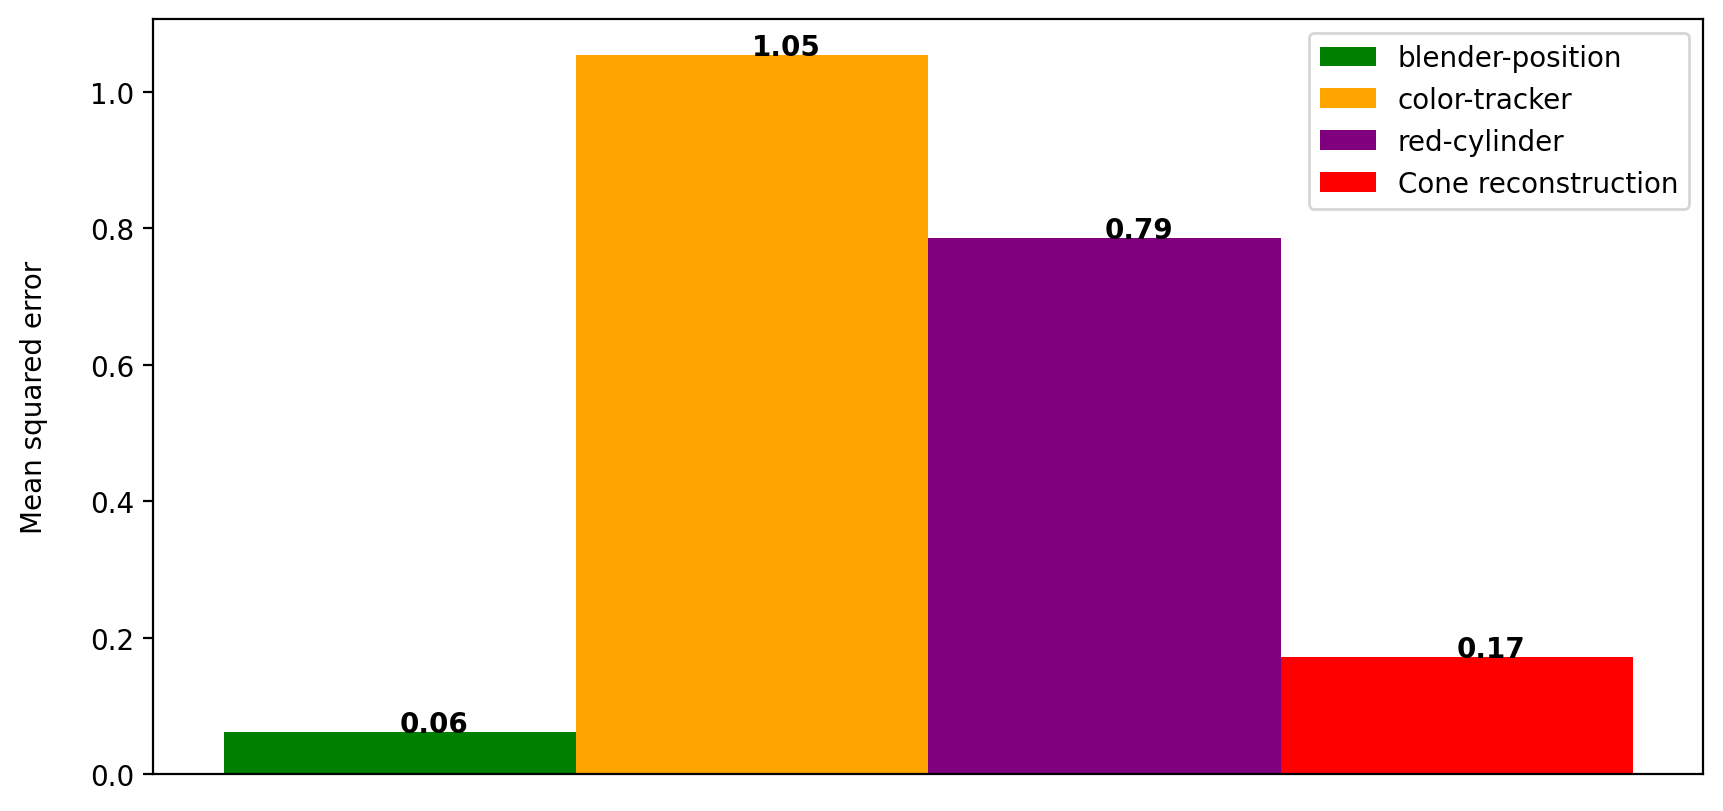

In [ ]:
plotMSE(normalize, 'CSRT-tracker')

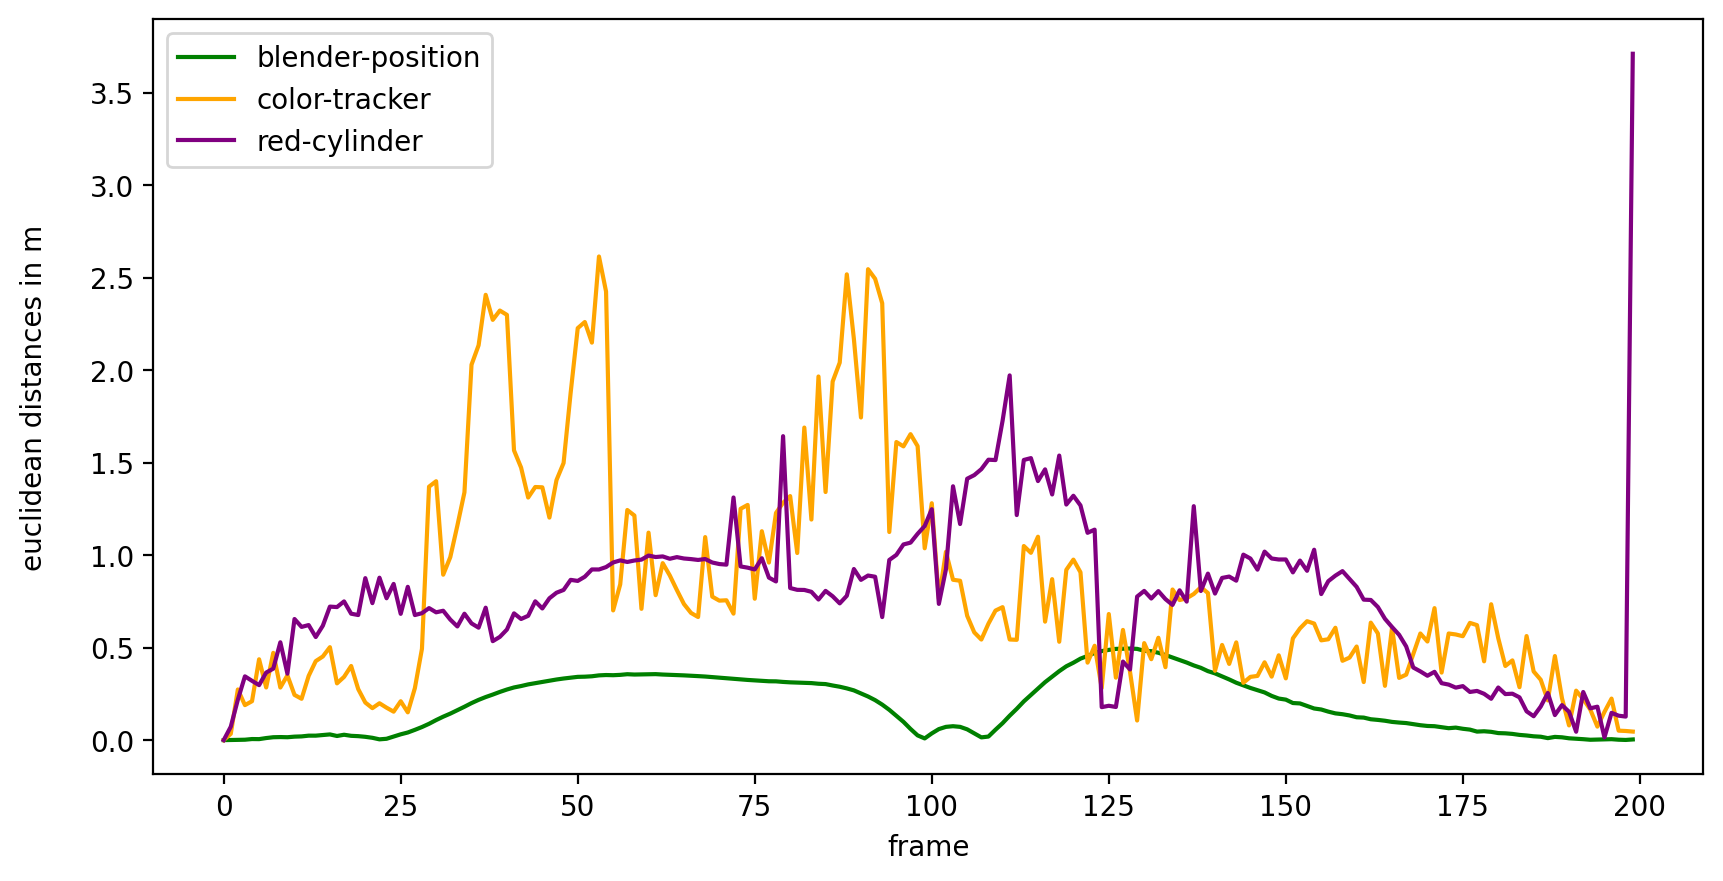

In [ ]:
plotEuclideanDistances(normalize, 'CSRT-tracker')

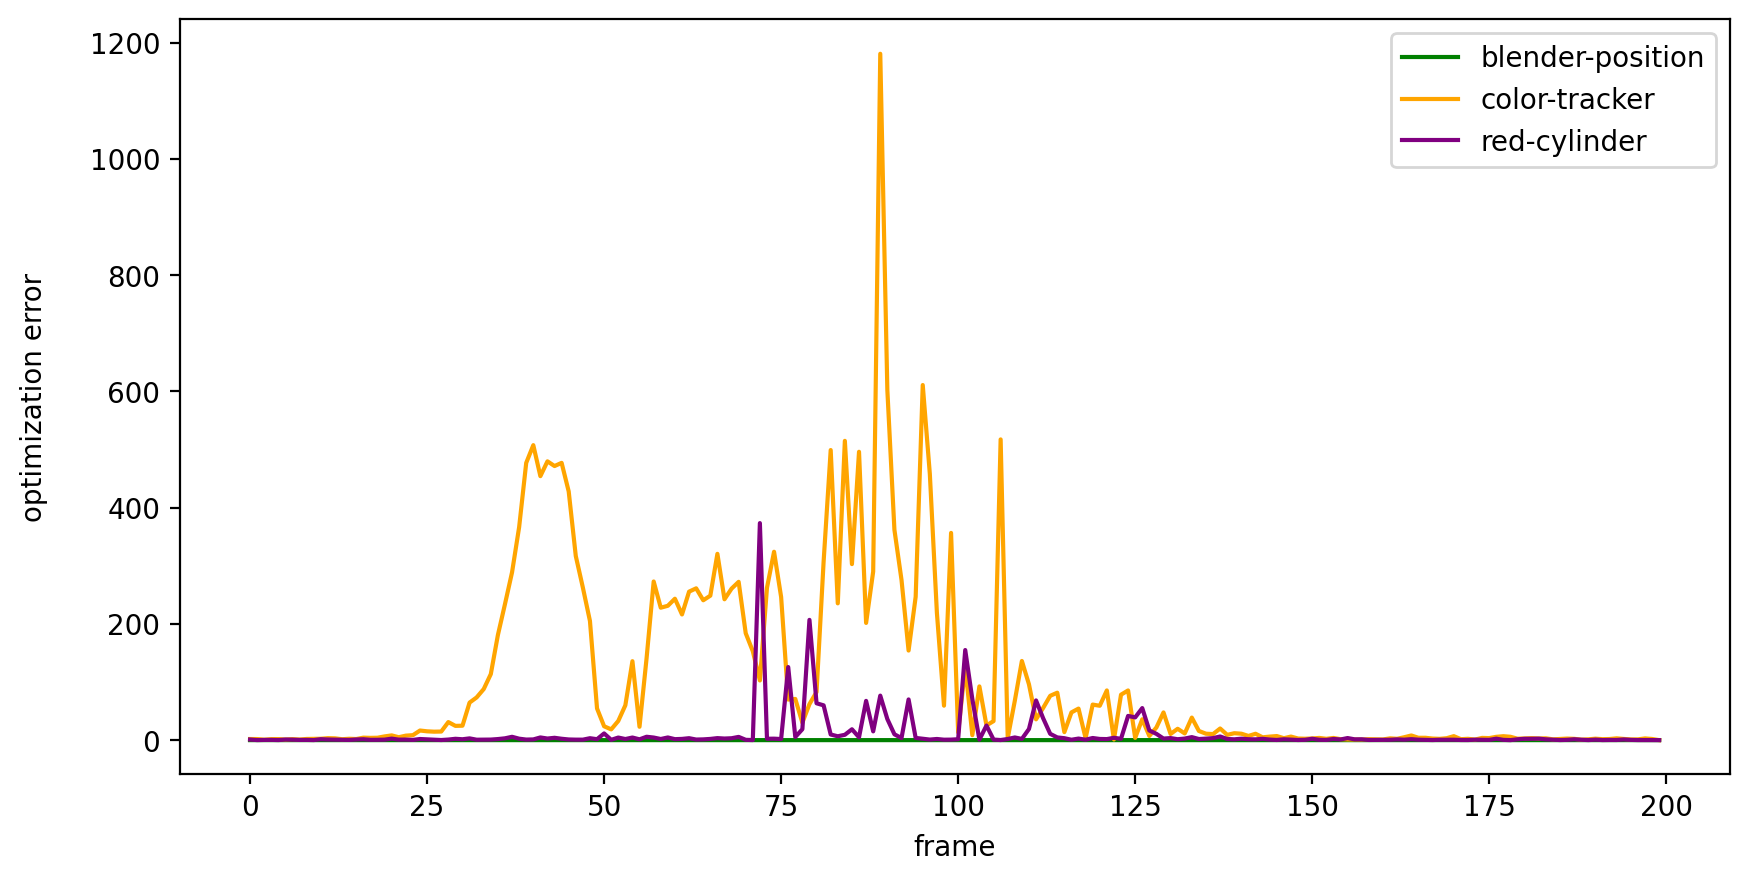

In [ ]:
plotOptimizationError(normalize, 'CSRT-tracker')

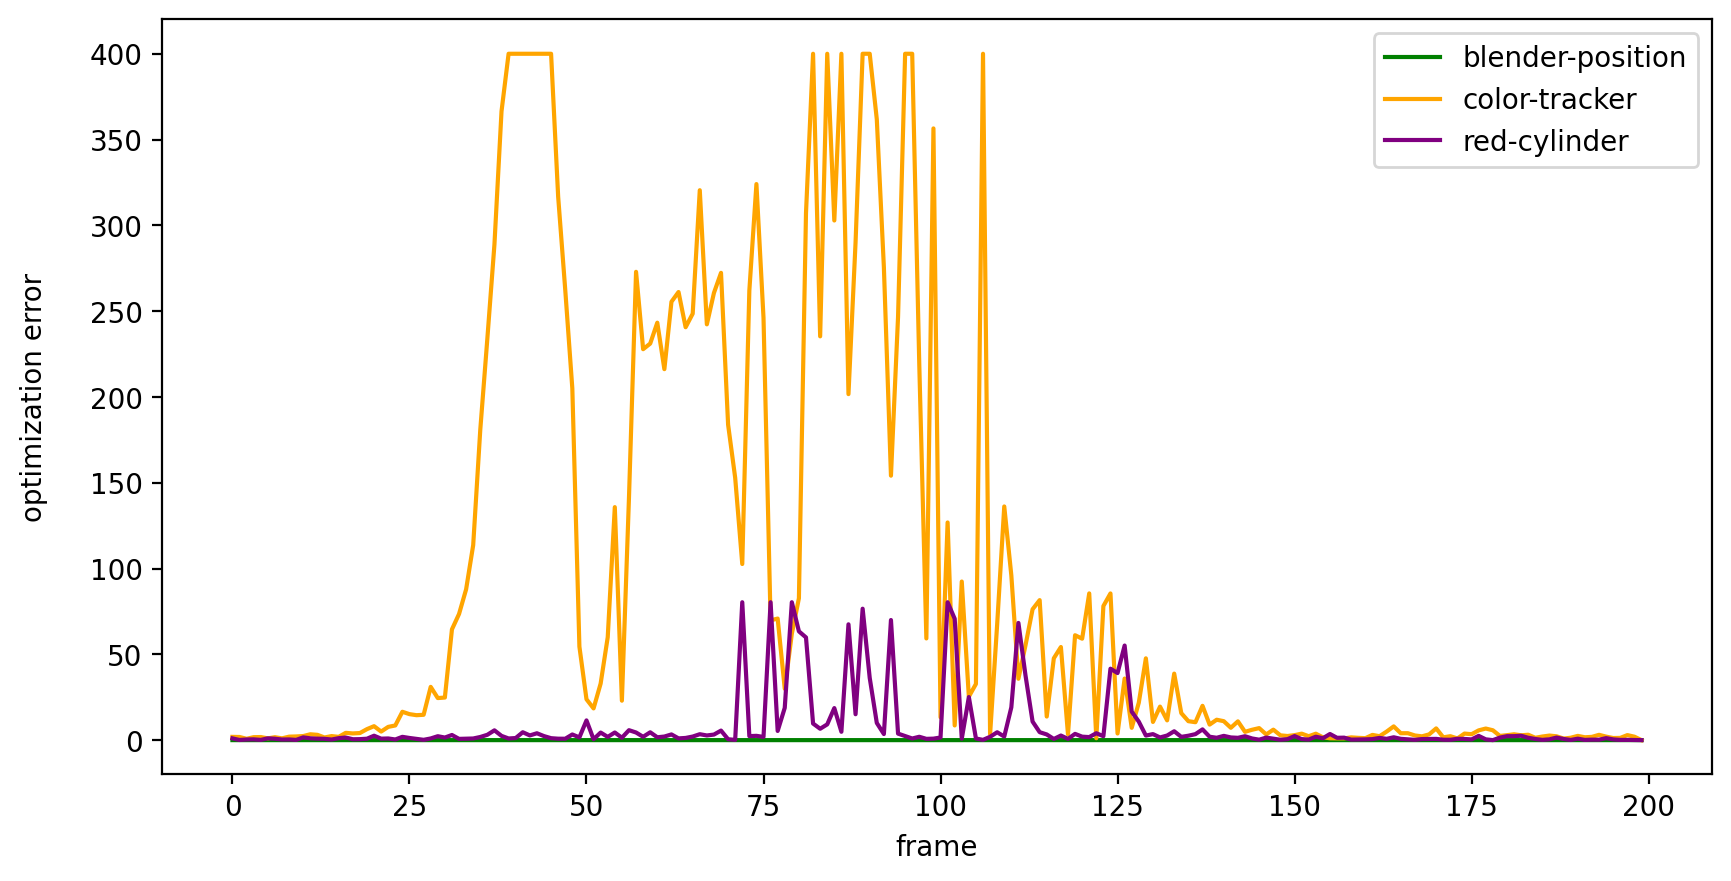

In [ ]:
# prune high optimization errors
max_threshold = 400
pruned_result = copy.deepcopy(normalize)
for result in pruned_result:
    threshold = np.mean(result.points_3D[:, 3]) + 2 * np.std(result.points_3D[:, 3])
    j = 0
    while j < result.points_3D.shape[0]:
        if result.points_3D[j, 3] > threshold or result.points_3D[j, 3] > max_threshold:
            # get next point greater than threshold
            i = j
            while result.points_3D[i, 3] > threshold or result.points_3D[i, 3] > max_threshold:
                i += 1
            # get diff to next point greater than threshold
            dist = i - j
            diff = result.points_3D[i, : 3] - result.points_3D[j, : 3]
            # replace point till i
            k = 1
            while j < i:
                result.points_3D[j, : 3] = result.points_3D[j, : 3] +  k/dist * diff 
                result.points_3D[j, 3] = threshold if threshold < max_threshold else max_threshold
                k += 1
                j += 1
        j +=1

plotOptimizationError(pruned_result, 'CSRT-tracker')

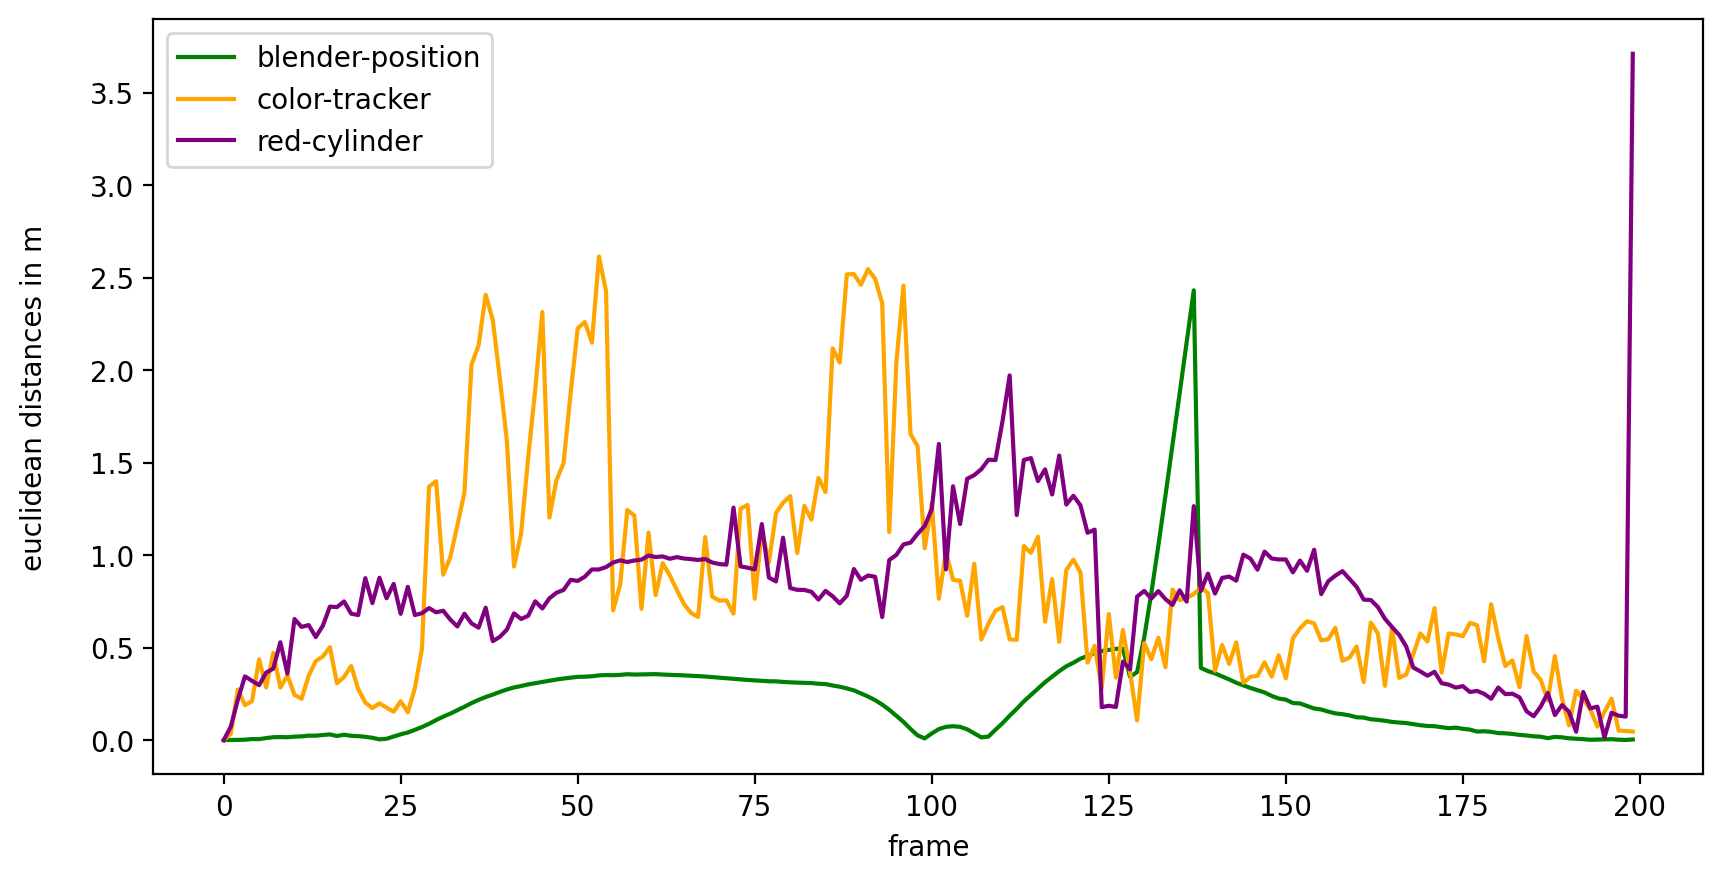

In [ ]:
plotEuclideanDistances(pruned_result, 'CSRT-tracker')

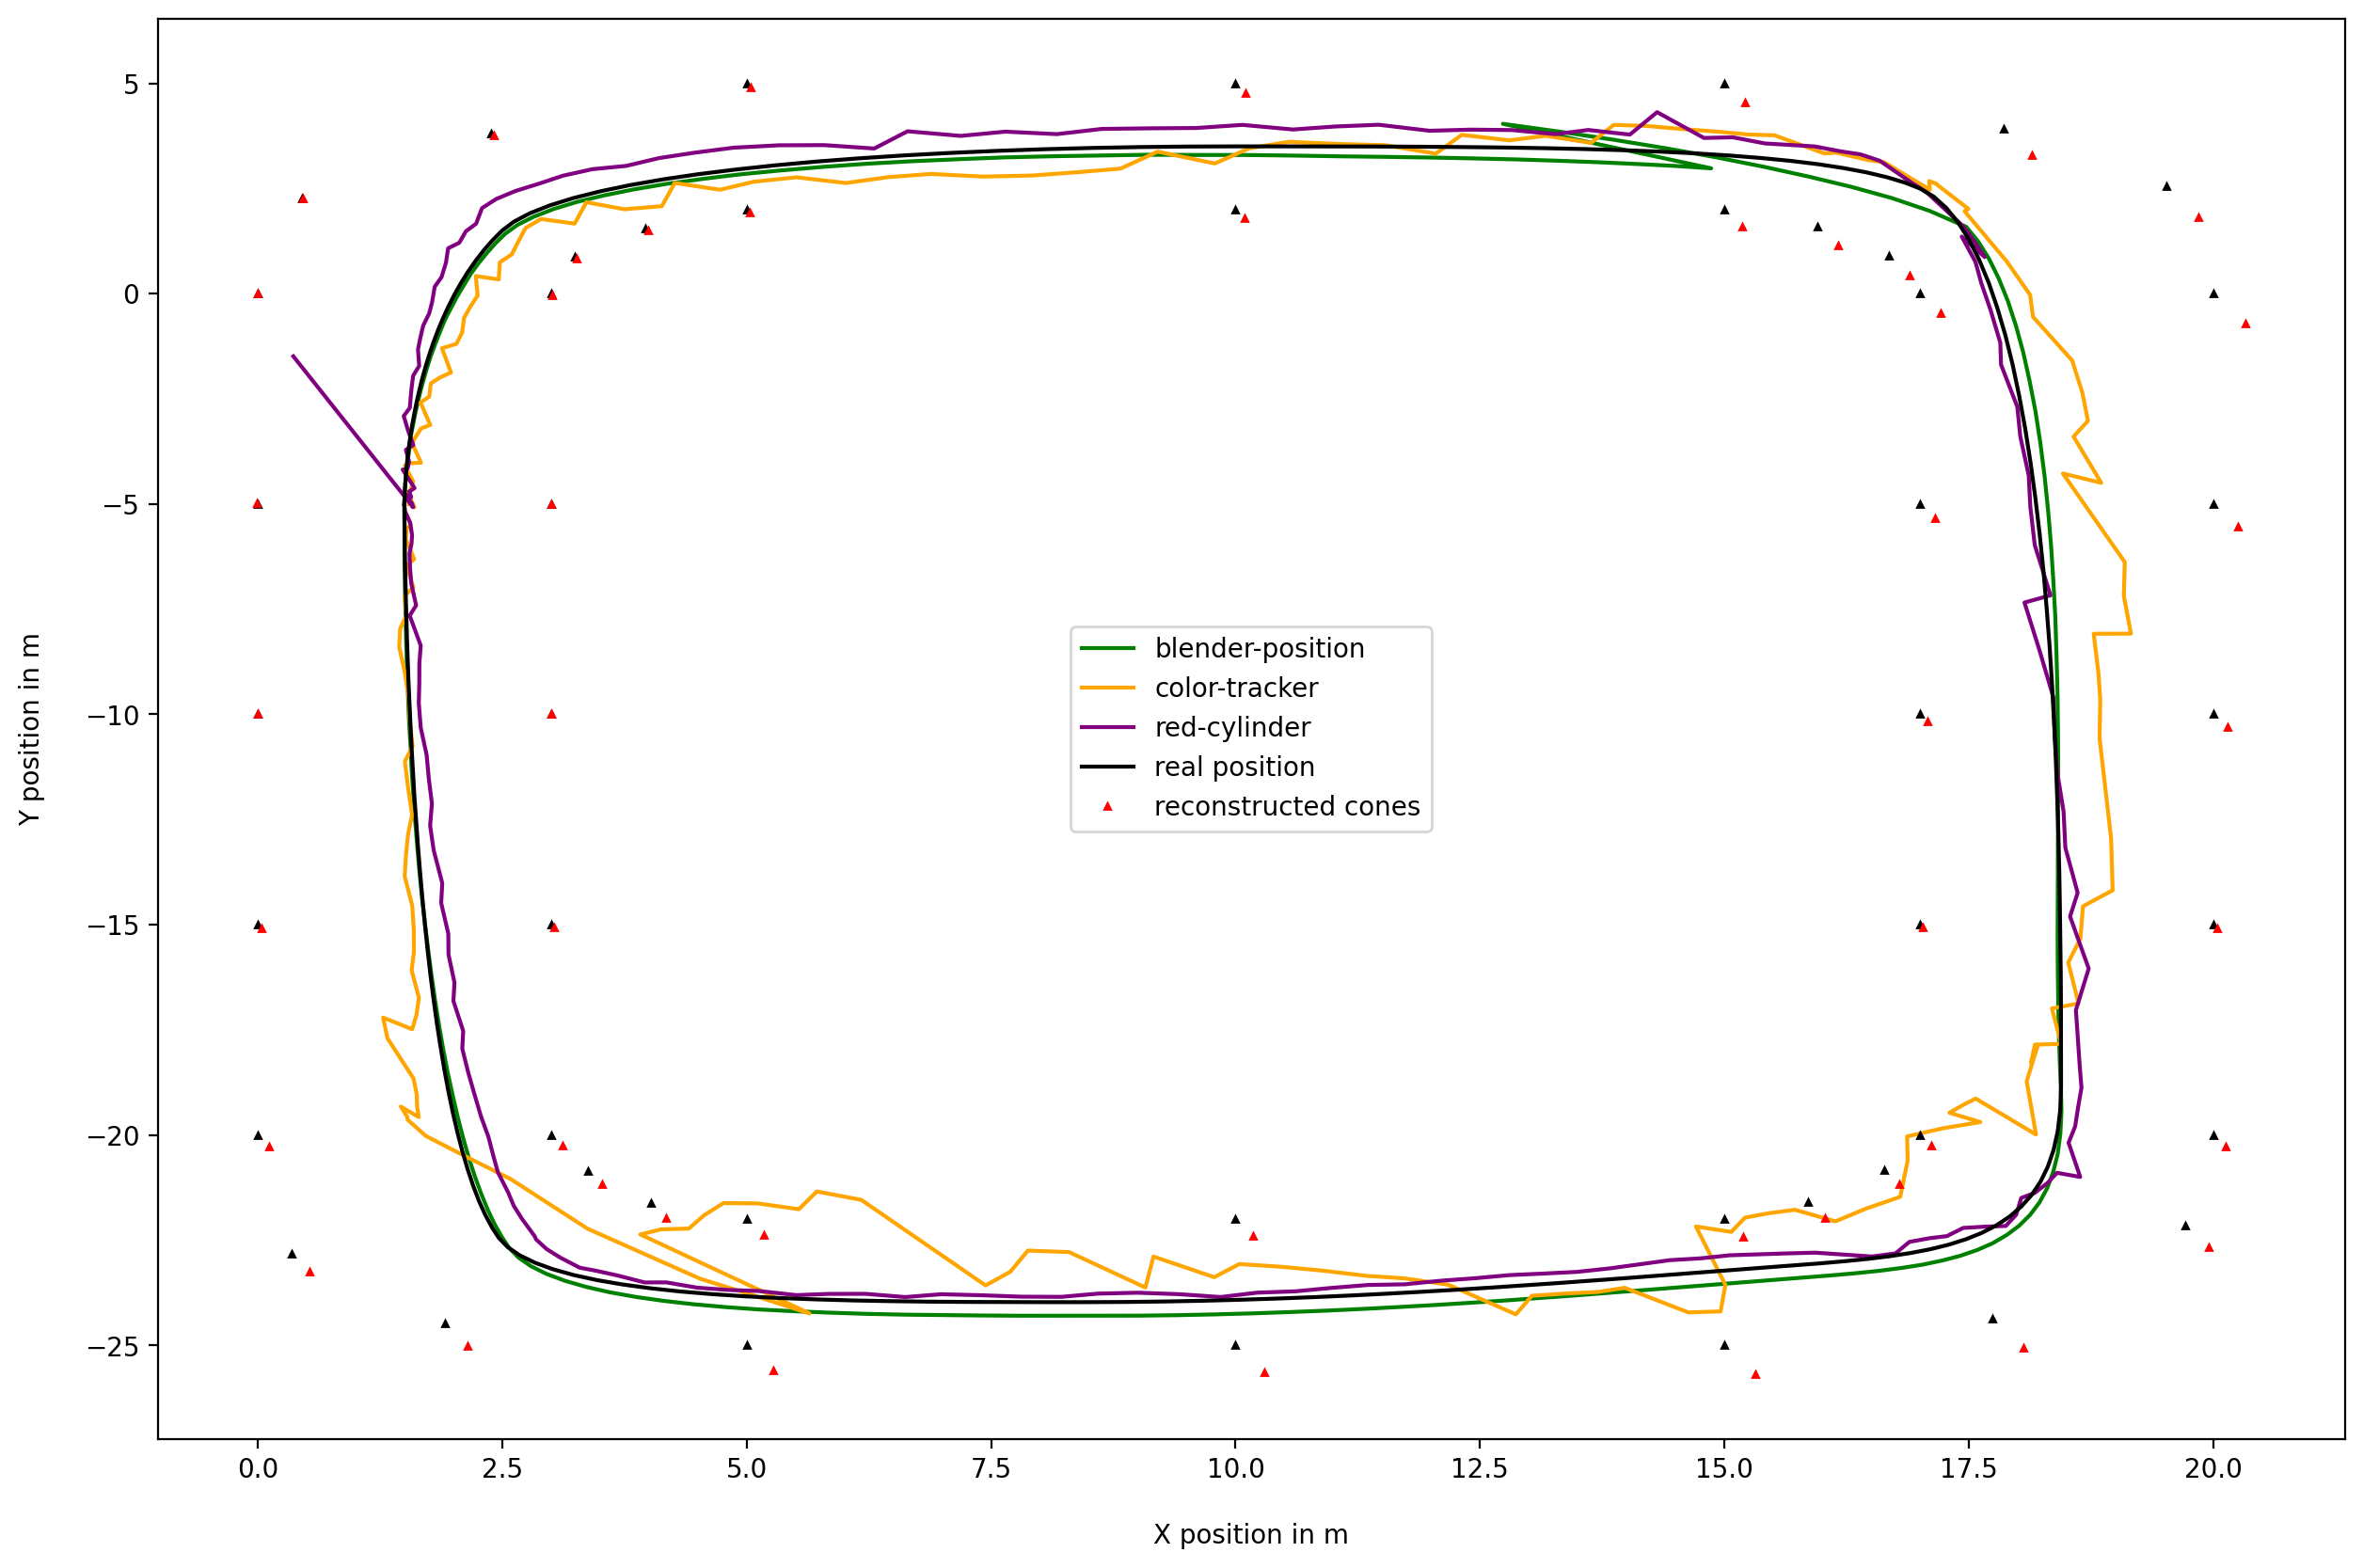

In [ ]:

plotTrack(pruned_result, 'CSRT-tracker')

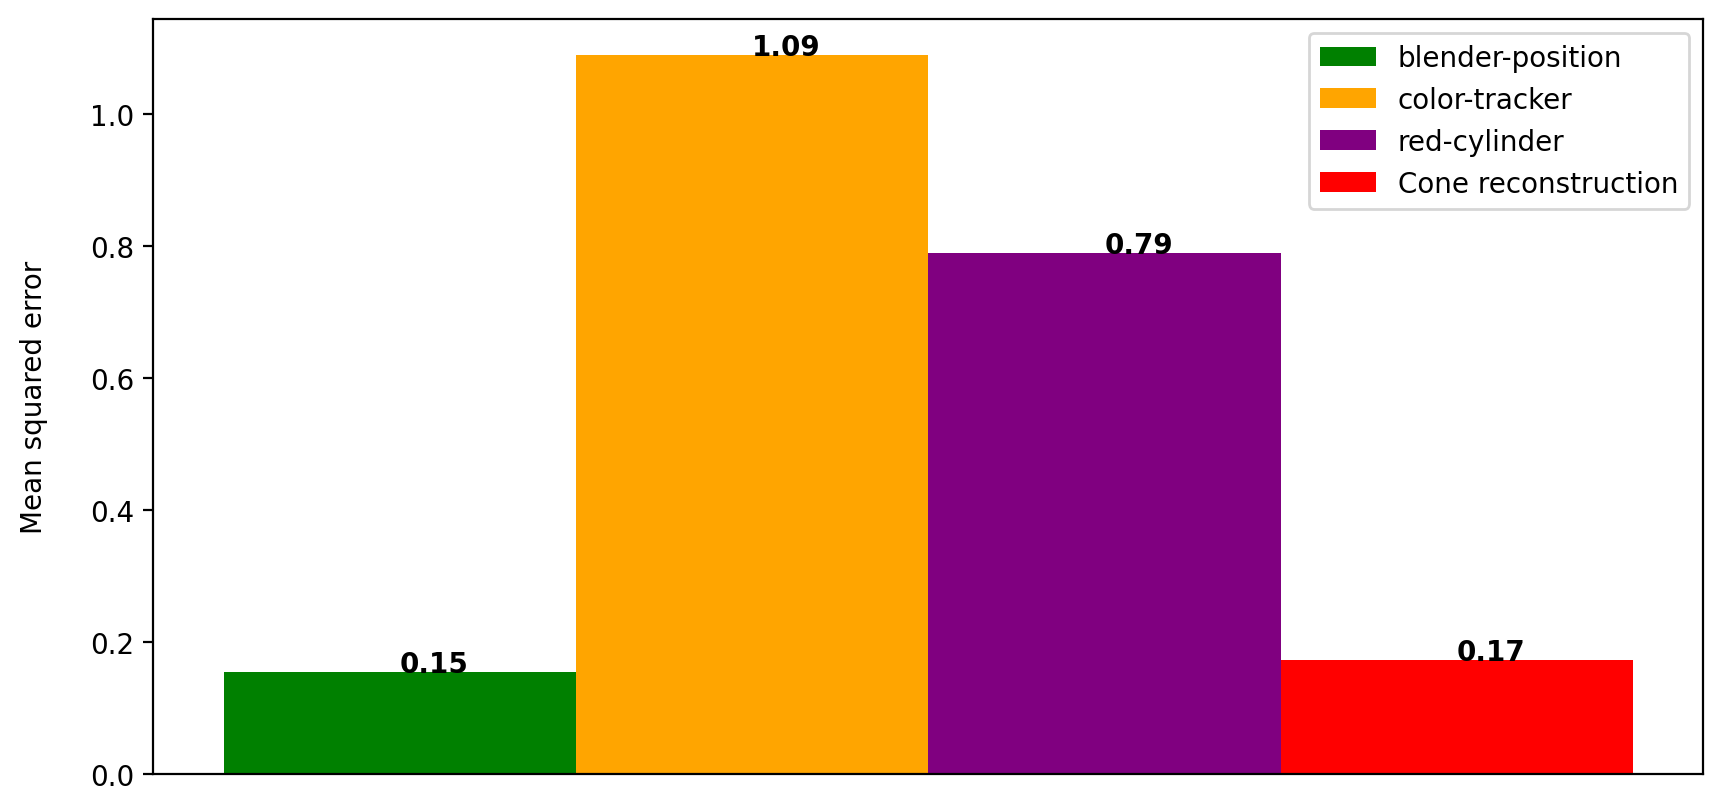

In [ ]:
plotMSE(pruned_result, 'CSRT-tracker')

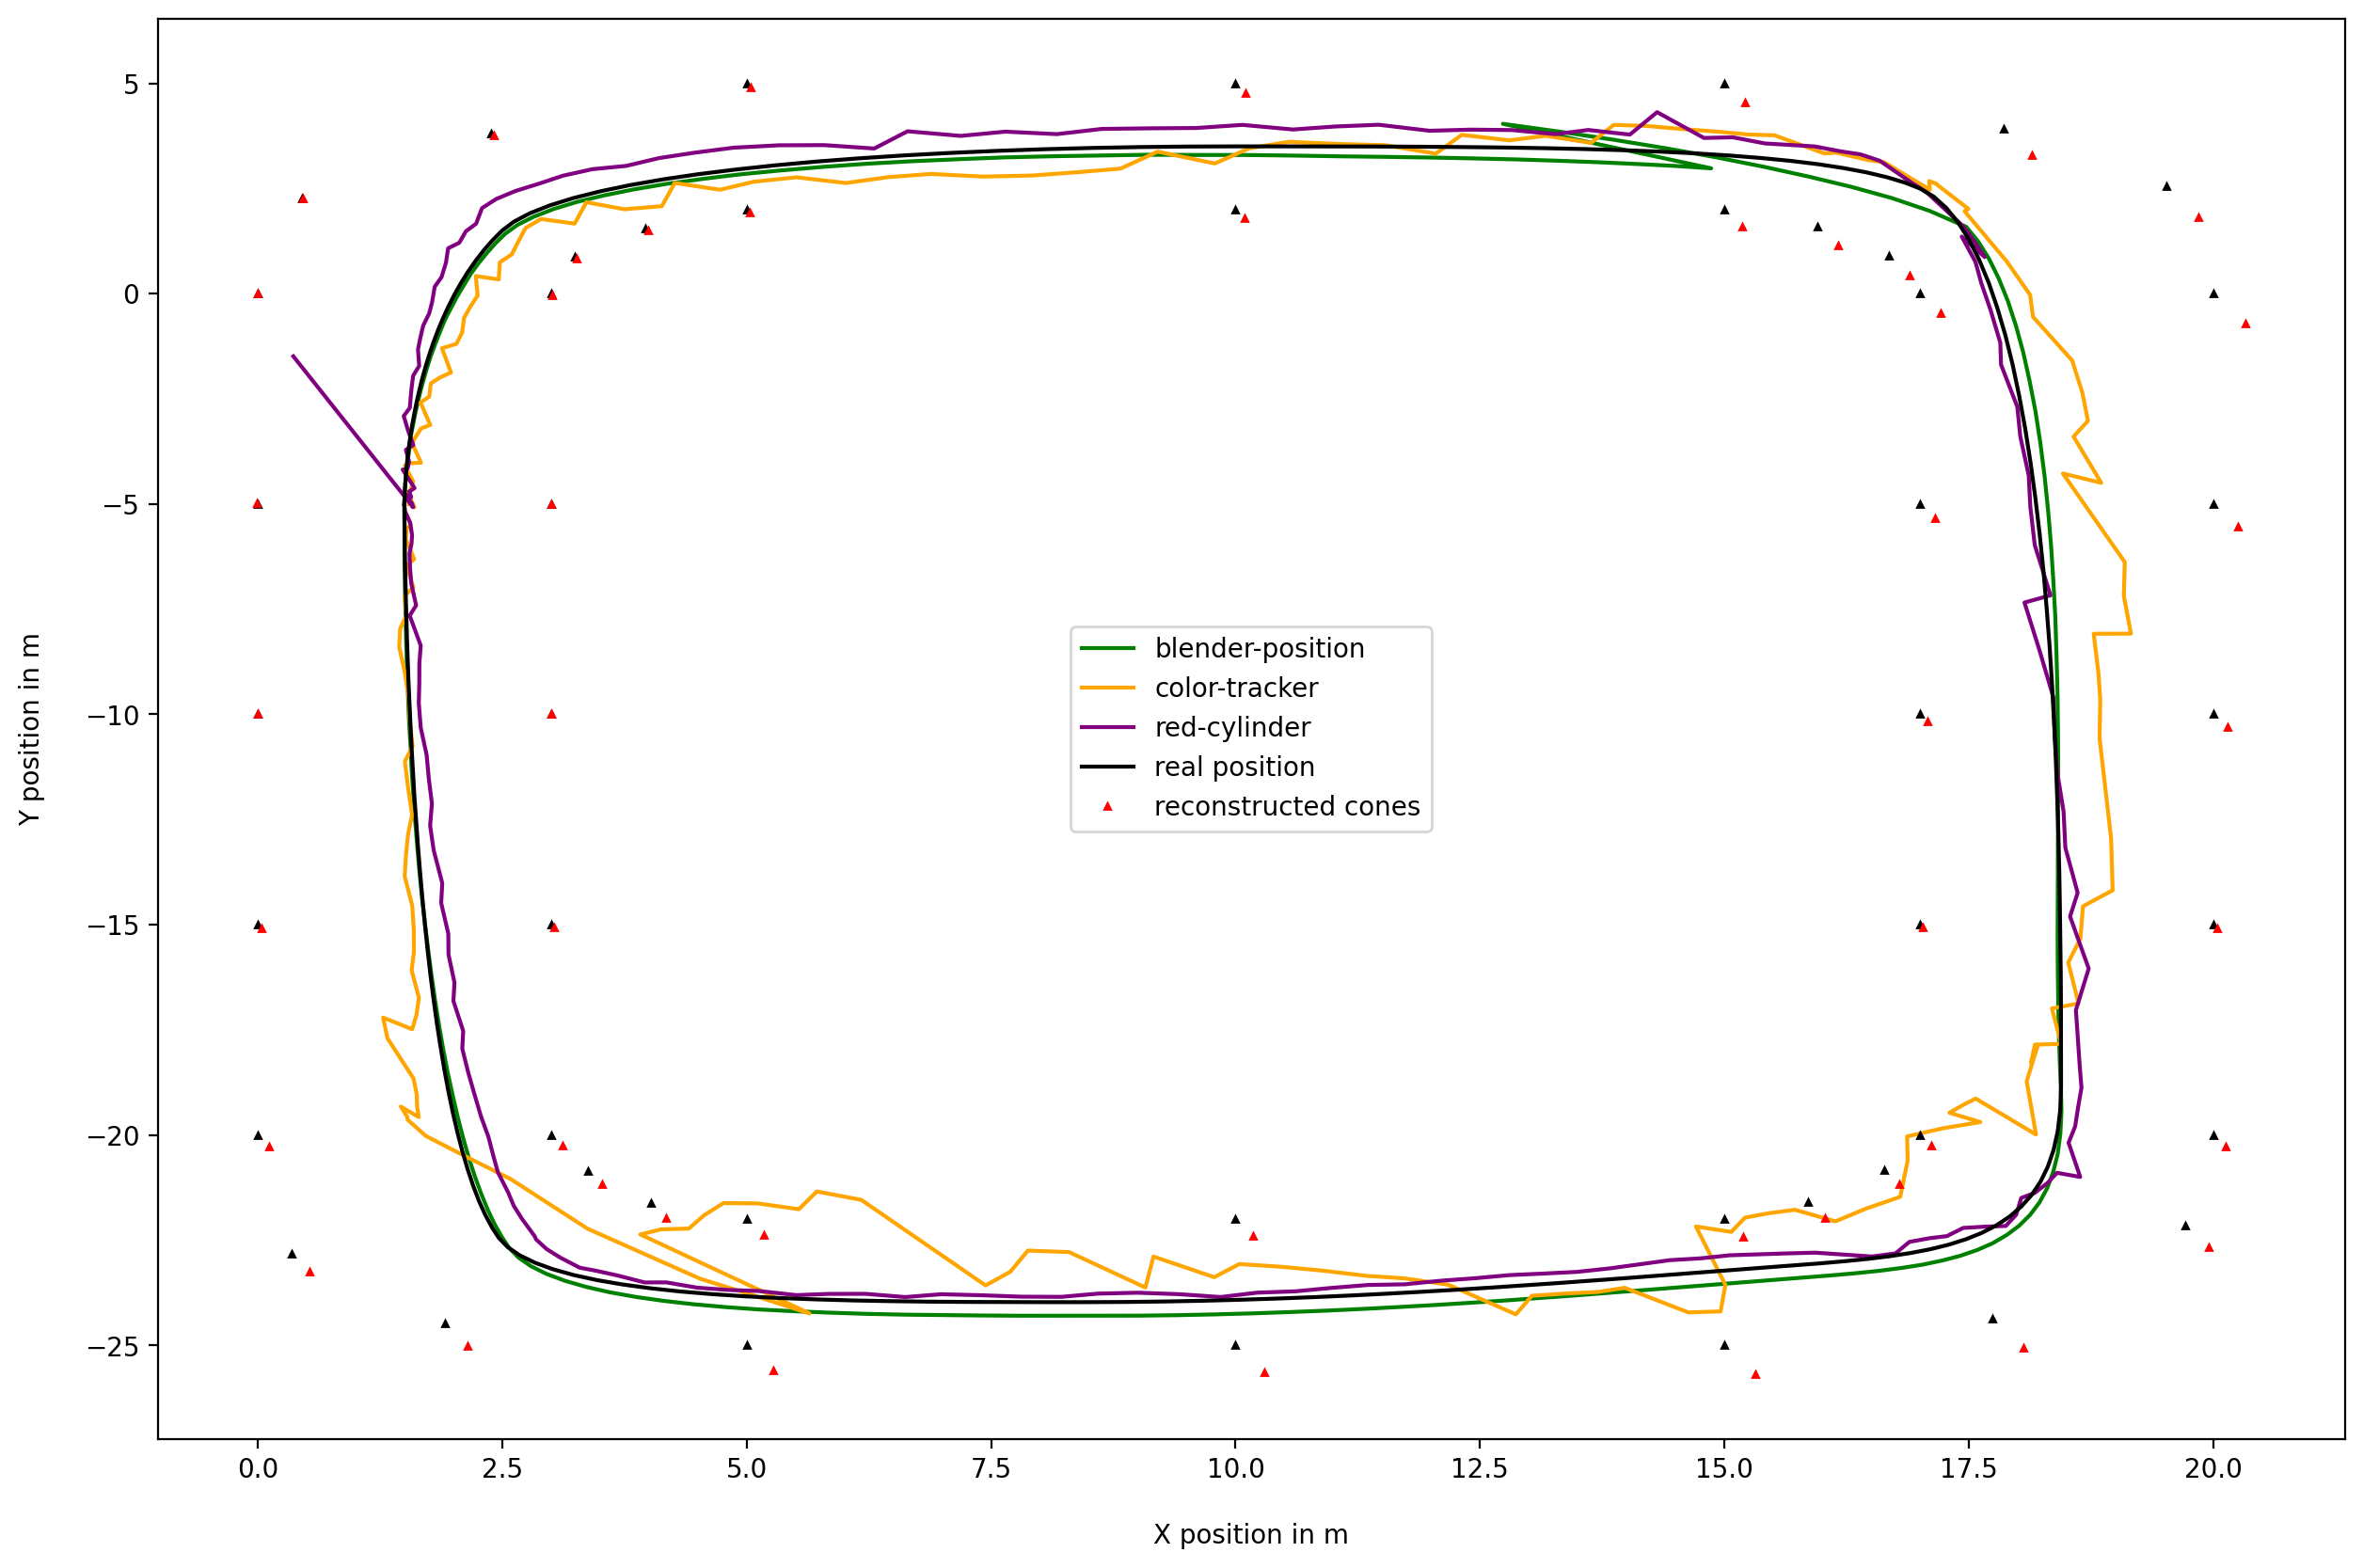

In [ ]:
# prune outliers in points_3D
rolled_points = copy.deepcopy(pruned_result)
for result in rolled_points:
    # calculate threshold
    mean_x = np.mean(result.points_3D[:,0])
    std_x = np.std(result.points_3D[:,0]) * 2
    mean_y = np.mean(result.points_3D[:,1])
    std_y = np.std(result.points_3D[:,1]) * 2
    # roll points
    j = 0
    while j < result.points_3D.shape[0]:
        if result.points_3D[j, 0] > mean_x + std_x  or result.points_3D[j, 0] < mean_x - std_x or result.points_3D[j, 1] > mean_y + std_y or result.points_3D[j, 1] < mean_y - std_y:
            # get next point greater than threshold
            i = j
            while result.points_3D[i, 0] > mean_x + std_x  or result.points_3D[i, 0] < mean_x - std_x or result.points_3D[i, 1] > mean_y + std_y or result.points_3D[i, 1] < mean_y - std_y:
                if (i < result.points_3D.shape[0] - 1):
                    i += 1
                break
            # get diff to next point greater than threshold
            dist = i - j
            diff = result.points_3D[i, : 3] - result.points_3D[j, : 3]
            # replace point till i
            k = 1
            while j < i:
                result.points_3D[j, : 3] = result.points_3D[j, : 3] +  k/dist * diff 
                k += 1
                j += 1
        j +=1


plotTrack(rolled_points, 'CSRT-tracker')

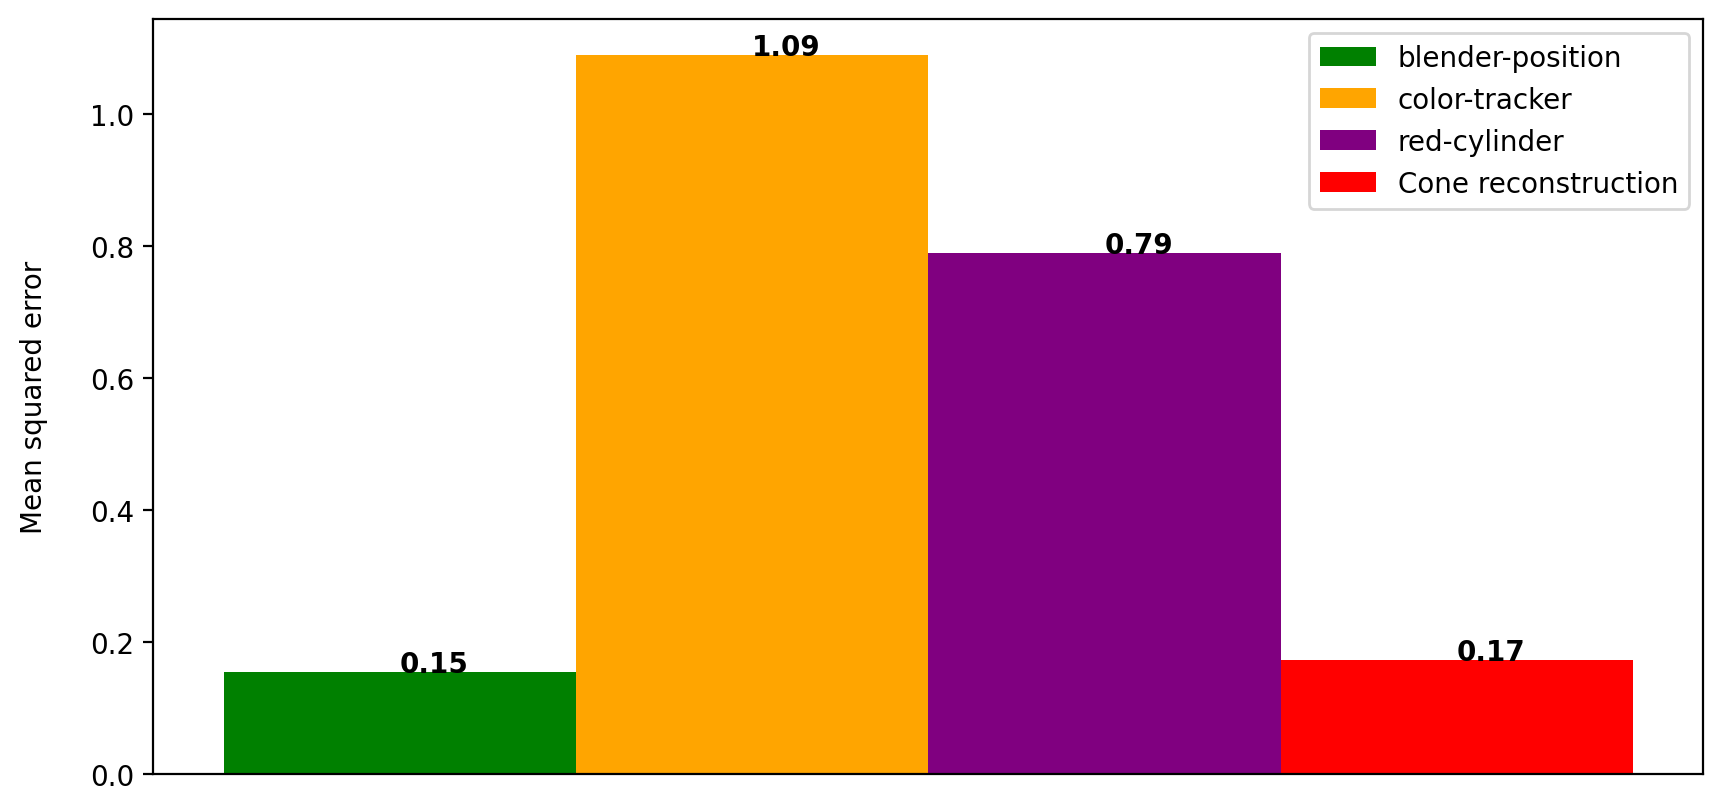

In [ ]:
plotMSE(rolled_points, 'CSRT-tracker')

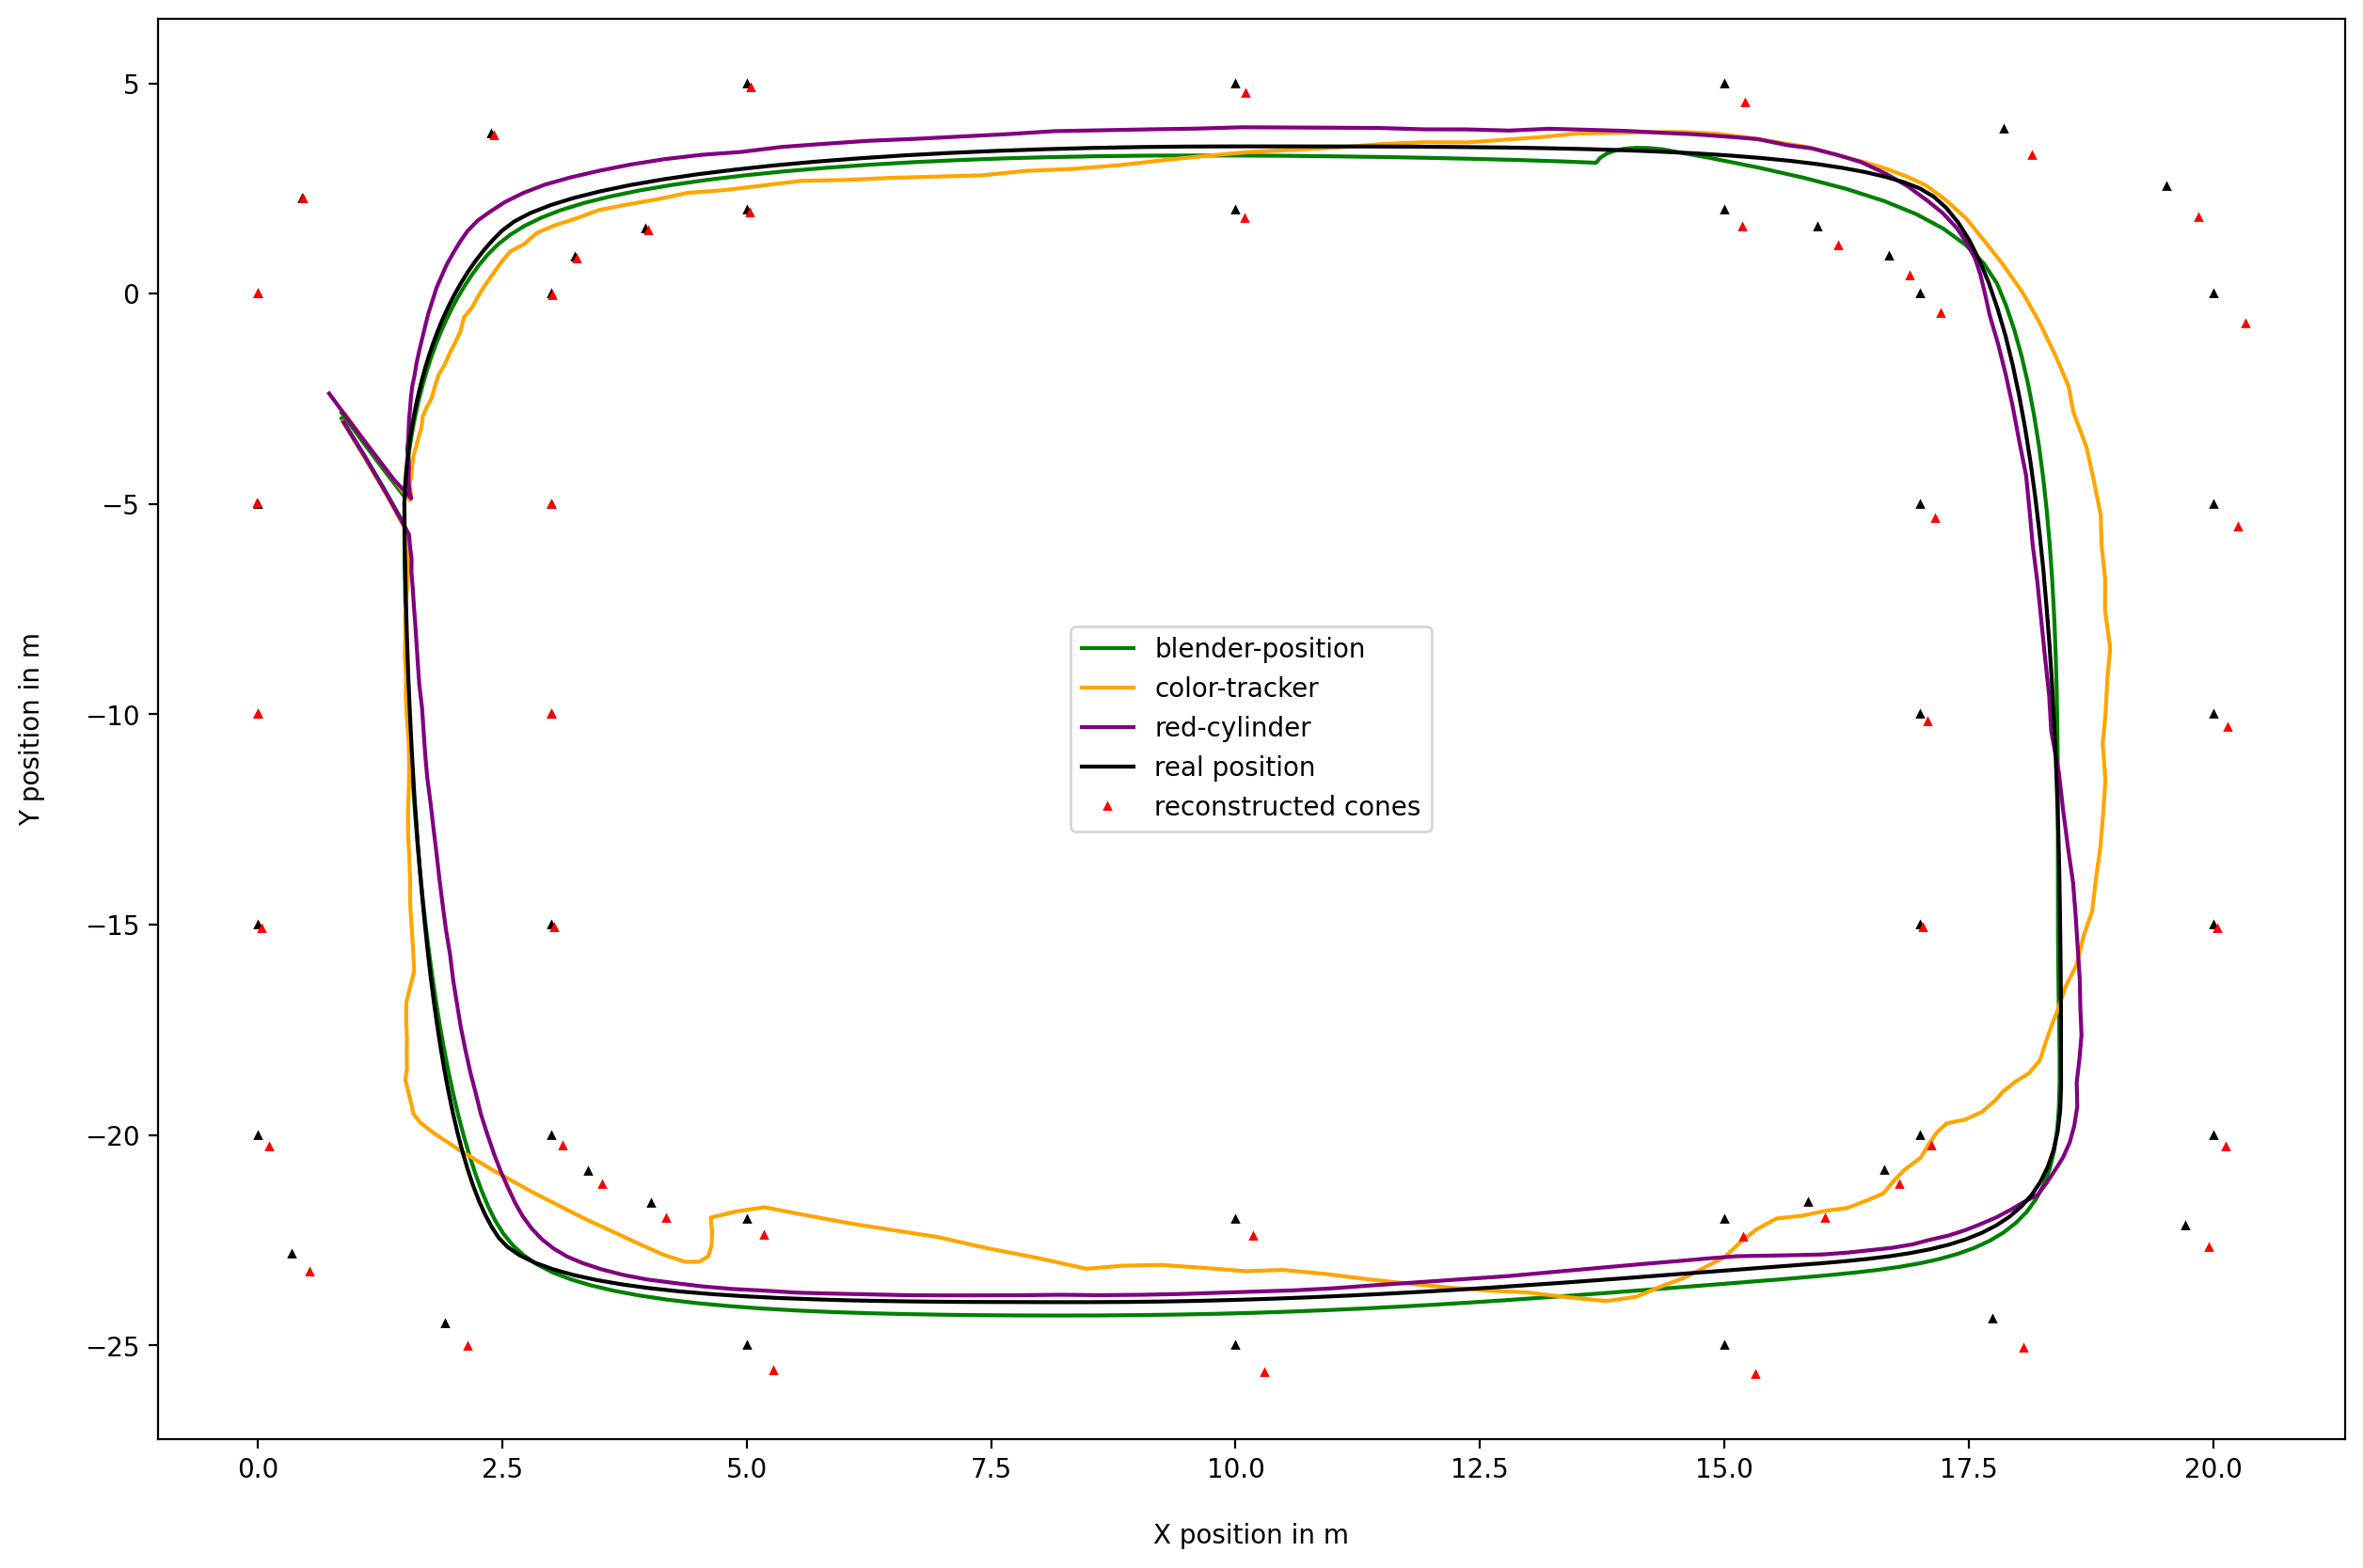

In [ ]:
# smooth lines
value=7
smoothened_results = copy.deepcopy(rolled_points)
for result in smoothened_results:
    result.points_3D[:, 0] = smooth(result.points_3D[:, 0], value)
    result.points_3D[:, 1] = smooth(result.points_3D[:, 1], value)
    result.points_3D[:, 2] = smooth(result.points_3D[:, 2], value)

plotTrack(smoothened_results, 'CSRT-tracker')

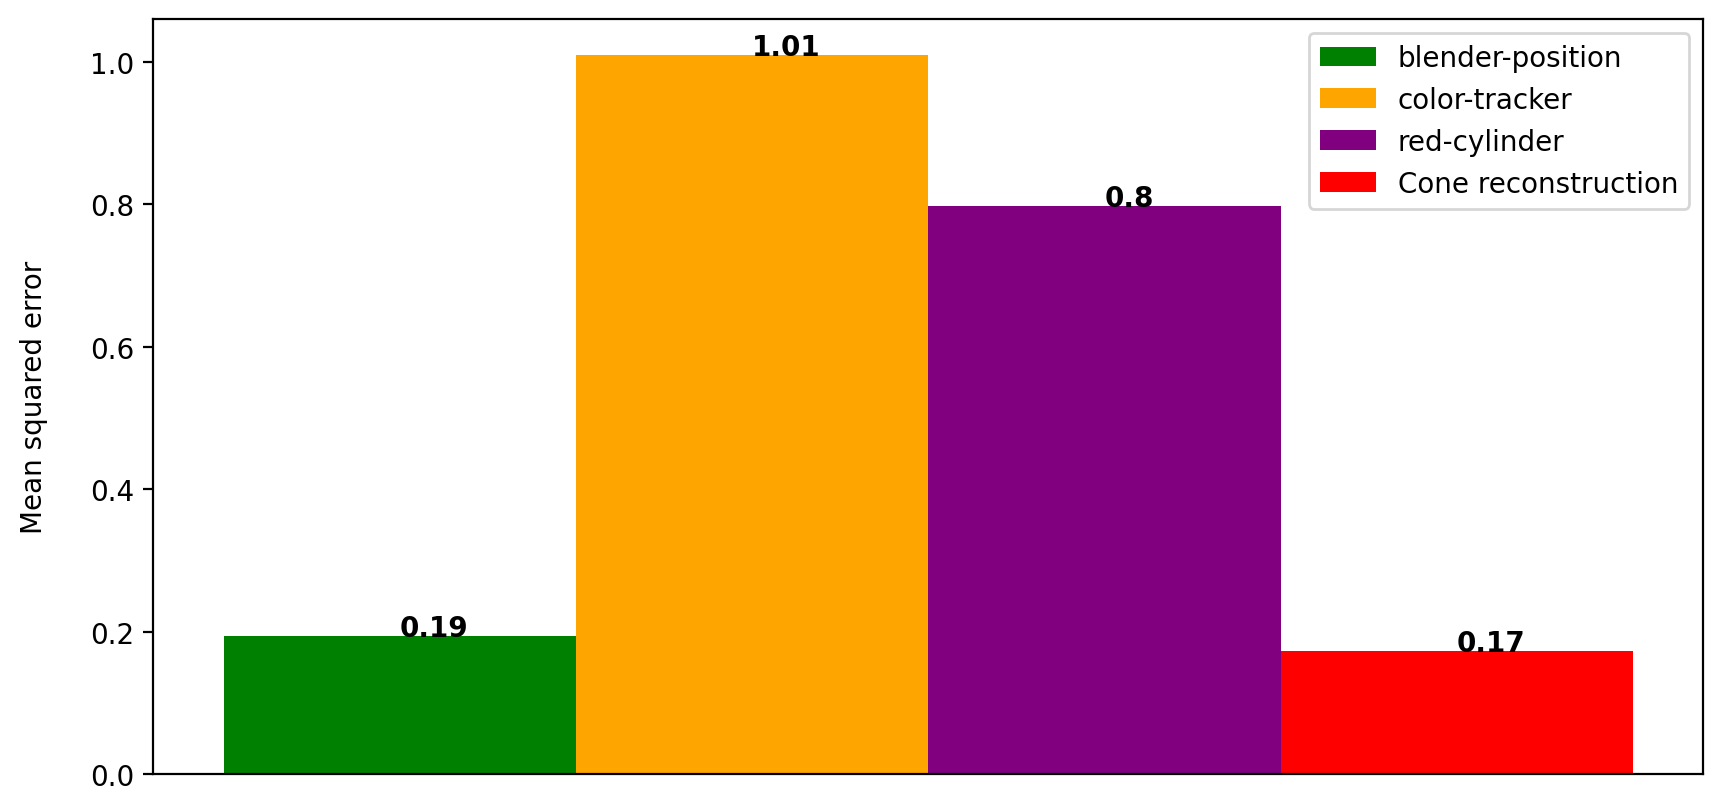

In [ ]:
plotMSE(smoothened_results, 'CSRT-tracker')